# Versionamento

V2: 
<ul>
    <li>Inclusão da variável categórica x28 que está relacionada com o tipo de papel em produção</li>
    <li>Feature Selection</li>
    <li>Feature Scalling</li>
</ul>

V3:
<ul>
    <li>Ajuste de parâmetros dos modelos</li>
</ul>

# O problema

Paper manufacturing can be viewed as a continuous rolling process. During this process, sometimes the paper breaks. If a break happens, the entire process is stopped, the reel is taken out, any found problem is fixed, and the production is resumed. The resumption can take more than an hour.

The cost of this lost production time is significant for a mill. Even a 5% reduction in the break events will give a significant cost saving for a mill. The objective of the given problem is to predict such breaks in advance (early prediction) and identify the potential cause(s) to prevent the break. 

To build such a prediction model, we will use the data collected from the network of sensors in a mill.

This is a multivariate time series data with break as the response (a
binary variable).
The provided data has,
<ul>
    <li>18,398 records.</li>
    <li>Columns:</li>
        <ul>
        <li>time: the timestamp of the row</li>
        <li>y: the binary response variable. There are only 124 rows with y = 1, rest are y = 0.</li>
        <li>x1-x61: predictor variables. All the predictors are continuous variables, except x28 and x61. x61 is a binary variable, and x28 is a
        categorical variable. All the predictors are centered. Besides, the predictors are a mixture of raw materials and process variables. Their descriptions are omitted for data anonymity.
            Several sensors are placed in different parts of the machine along its length
and breadth. These sensors measure both raw materials (e.g. amount of pulp
fiber, chemicals, etc.) and process variables (e.g. blade type, couch vacuum,
rotor speed, etc.).</li>
        </ul>
</ul>

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import datetime

# Load Data

In [2]:
pwbdatafile = '..\\data\\processminer-rare-event-mts-data.csv'
pwbds = pd.read_csv(pwbdatafile)

In [3]:
pwbds.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [4]:
pwbds.shape

(18009, 63)

In [5]:
pwbds.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
count,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,...,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000
mean,0.006830,0.035331,0.103388,0.502687,-12.573059,0.008110,2.316316,0.004256,-0.005172,-0.005156,...,0.413040,0.400073,0.119113,2.375554,10.559560,0.263504,-0.002106,-0.066821,0.001513,0.001055
std,0.082363,0.730243,4.957904,5.953075,130.997830,0.639591,37.224167,0.108337,0.075598,0.145683,...,6.274133,14.323519,3.038758,68.610467,81.552661,2.341876,0.049119,10.451196,0.004433,0.032465
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-187.943440,-1817.595500,-8.210370,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.007467,0.000000
25%,0.000000,-0.359034,-2.242758,-3.610612,-112.090980,-0.452250,-24.595360,-0.049319,-0.051043,-0.059966,...,-3.804520,-1.893986,0.471525,-41.054135,-45.360800,-1.653737,0.000747,0.293452,-0.001699,0.000000
50%,0.000000,0.140347,-0.129576,-0.353550,-17.172632,-0.121546,10.111336,0.000732,-0.011064,-0.030057,...,0.294846,0.163143,0.654139,18.547672,3.833948,0.085826,0.013077,0.736788,0.000964,0.000000
75%,0.000000,0.427898,2.277959,3.365069,84.982124,0.336385,32.676766,0.060853,0.038986,-0.000149,...,5.312424,3.533260,2.665483,44.583805,64.510522,2.222118,0.021056,1.272997,0.004291,0.000000
max,1.000000,3.054156,16.742105,15.900116,334.694098,4.239385,96.060768,1.705590,0.788826,3.206675,...,14.180588,11.148006,6.475137,287.252017,252.147455,6.922008,0.060264,6.985460,0.020510,1.000000


In [6]:
pwbds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18009 entries, 0 to 18008
Data columns (total 63 columns):
time    18009 non-null object
y       18009 non-null int64
x1      18009 non-null float64
x2      18009 non-null float64
x3      18009 non-null float64
x4      18009 non-null float64
x5      18009 non-null float64
x6      18009 non-null float64
x7      18009 non-null float64
x8      18009 non-null float64
x9      18009 non-null float64
x10     18009 non-null float64
x11     18009 non-null float64
x12     18009 non-null float64
x13     18009 non-null float64
x14     18009 non-null float64
x15     18009 non-null float64
x16     18009 non-null float64
x17     18009 non-null float64
x18     18009 non-null float64
x19     18009 non-null float64
x20     18009 non-null float64
x21     18009 non-null float64
x22     18009 non-null float64
x23     18009 non-null float64
x24     18009 non-null float64
x25     18009 non-null float64
x26     18009 non-null float64
x27     18009 non-null flo

# Exploratory Analysis

In [7]:
def displayCategorical(yvar):   
    fig, ax = plt.subplots()
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['text.color'] = '#909090'
    plt.rcParams['axes.labelcolor']= '#909090'
    plt.rcParams['xtick.color'] = '#909090'
    plt.rcParams['ytick.color'] = '#909090'
    plt.rcParams['font.size']=12
    labels = yvar.value_counts().keys()
    percentages = list (map(lambda x:round(x*100,2),yvar.value_counts().values/pwbds.shape[0]))
    ax.pie(percentages, labels=labels,  
           autopct='%1.0f%%', 
           shadow=False, startangle=0,   
           pctdistance=1.2,labeldistance=1.4)
    ax.axis('equal')
    ax.set_title("Distribution")
    ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

The change in the level of the categorical variable, x28, may be more important than its actual value. This variable is related to the type of paper produced at that time. For this prediction model, it might be more important to capture any change in the paper type instead of the actual type of the paper.
May consider adding a feature capturing the change in x28, e.g. x28t − x28t−1.

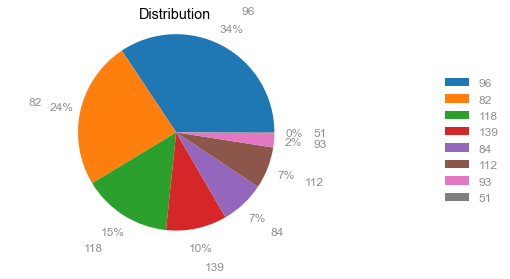

In [8]:
displayCategorical(pwbds['x28'])

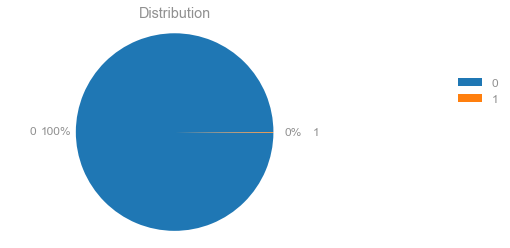

In [9]:
displayCategorical(pwbds['x61'])

In [10]:
# A distribuição de x61 indica que podemos descartá-la no processo
pwbds.drop('x61',axis='columns', inplace=True)

In [11]:
# Now, the target
pwbds.y.value_counts()

0    17886
1      123
Name: y, dtype: int64

123 registros de quebra da teia

In [12]:
train_ind = int(0.8 * pwbds.shape[0])
y_test = pwbds.y[train_ind:]
np.unique(y_test,return_counts=True)

(array([0, 1], dtype=int64), array([3568,   34], dtype=int64))

Haverá 34 eventos de quebra no conjunto de teste

## Verifica features nos momentos de quebra

In [13]:
pwbds.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
count,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,...,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000,18009.000000
mean,0.006830,0.035331,0.103388,0.502687,-12.573059,0.008110,2.316316,0.004256,-0.005172,-0.005156,...,-3.873028,0.413040,0.400073,0.119113,2.375554,10.559560,0.263504,-0.002106,-0.066821,0.001513
std,0.082363,0.730243,4.957904,5.953075,130.997830,0.639591,37.224167,0.108337,0.075598,0.145683,...,350.911316,6.274133,14.323519,3.038758,68.610467,81.552661,2.341876,0.049119,10.451196,0.004433
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-3652.989000,-187.943440,-1817.595500,-8.210370,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.007467
25%,0.000000,-0.359034,-2.242758,-3.610612,-112.090980,-0.452250,-24.595360,-0.049319,-0.051043,-0.059966,...,29.984624,-3.804520,-1.893986,0.471525,-41.054135,-45.360800,-1.653737,0.000747,0.293452,-0.001699
50%,0.000000,0.140347,-0.129576,-0.353550,-17.172632,-0.121546,10.111336,0.000732,-0.011064,-0.030057,...,29.984624,0.294846,0.163143,0.654139,18.547672,3.833948,0.085826,0.013077,0.736788,0.000964
75%,0.000000,0.427898,2.277959,3.365069,84.982124,0.336385,32.676766,0.060853,0.038986,-0.000149,...,29.984624,5.312424,3.533260,2.665483,44.583805,64.510522,2.222118,0.021056,1.272997,0.004291
max,1.000000,3.054156,16.742105,15.900116,334.694098,4.239385,96.060768,1.705590,0.788826,3.206675,...,40.152348,14.180588,11.148006,6.475137,287.252017,252.147455,6.922008,0.060264,6.985460,0.020510


In [14]:
desc = pwbds.describe()
brkcols = [
    'x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20',
    'x21','x22','x23','x24','x25','x26','x27','x29','x30','x31','x32','x33','x34','x35','x36','x37','x38','x39','x40',
    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','x51','x52','x53','x54','x55','x56','x57','x58','x59','x60',
    ]

dicts_list=[]
for col in brkcols:
#    print (col, ':',(pwbds.loc[pwbds.y==1][col] > desc.loc['max',col]*0.9).sum())
    dict_row = {'feature':col,
         'max_no':(pwbds.loc[pwbds.y==1][col] >= desc.loc['max',col]*0.9).sum(),
         'min_no':(pwbds.loc[pwbds.y==1][col] <= desc.loc['min',col]*0.1).sum()
    }
    dicts_list.append(dict_row)

anomalies = pd.DataFrame(dicts_list)
anomalies

,feature,max_no,min_no
0,x1,1,29
1,x2,0,77
2,x3,1,104
3,x4,1,55
4,x5,1,62
5,x6,0,47
6,x7,0,34
7,x8,1,42
8,x9,0,72
9,x10,0,66


In [15]:
#pwbds['date'] = pwbds['time'].str.split(' ').str[0]
#pwbds['time'] = pwbds['time'].str.split(' ').str[1]
pwbds['time']= pd.to_datetime(pwbds['time'])

## Check total downtime

In [16]:
def calcDownTime(ds):
    dstmp = ds.copy()
    dstmp["next_measure"] = dstmp["time"].shift(-1)
    dstmp['downtime'] = dstmp['next_measure'] - dstmp['time']
    downtimes = dstmp.loc[dstmp['y']==1][['time', 'downtime']].copy()
    return (dstmp.groupby(['y'])['downtime'].agg('sum').iloc[1,],downtimes)

In [17]:
totalPeriod = pwbds.tail(1)['time'].iloc[0,] - pwbds.head(1)['time'].iloc[0,]
totalDowntime,dtds = calcDownTime(pwbds)
perc = round ((totalDowntime/totalPeriod)*100,2)
print ('Downtime total de:', totalDowntime, 'num período de: ', totalPeriod, 'correspondendo a: ',perc,'%')

Downtime total de: 1 days 21:40:00 num período de:  27 days 10:48:00 correspondendo a:  6.93 %


## Breaks per day

In [18]:
dtds['time'] = dtds['time'].astype(str)
dtds['time'] = dtds['time'].str.split(' ').str[0]

In [19]:
# Determine max_slots
max_slots = dtds.time.value_counts().max()
slot_size = len(dtds.time.value_counts()) 

In [20]:
dtds['downtime']=dtds['downtime'].dt.total_seconds()/60

In [21]:
# Monta numero de listas correspondentes à max_slots, de tamanho correspondente ao número de dias
downtime_matrix = np.zeros([max_slots,slot_size])
day_idx=0
reg_idx=0
lista_idx=-1
last_day = dtds['time'].iloc[0,]
for day in dtds['time'].tolist():
    if (day != last_day):
        lista_idx=0
        last_day = day
        day_idx+=1
    else:
        lista_idx+=1
    downtime_matrix[lista_idx,day_idx]=dtds.downtime.iloc[reg_idx,]
    reg_idx+=1

In [22]:
downtimedf = pd.DataFrame (downtime_matrix.T)
downtimedf['day'] = dtds.time.value_counts().sort_index().index

In [23]:
downtimedf = downtimedf.set_index('day')

Text(0, 0.5, 'Downtime minutes')

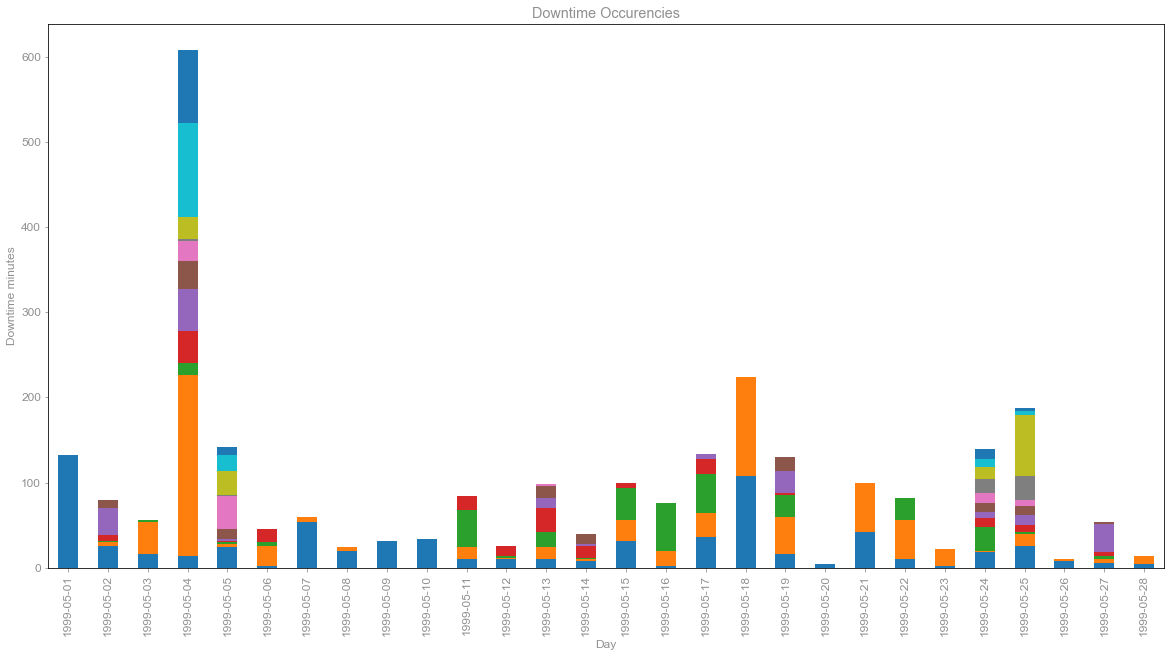

In [24]:
downtimedf.plot(kind="bar",stacked=True, legend=None,figsize=(20, 10))
plt.title("Downtime Occurencies")
plt.xlabel("Day")
plt.ylabel("Downtime minutes")

## Comportamento de cada feature no tempo

In [25]:
cols = [
    'y','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20',
    'x21','x22','x23','x24','x25','x26','x27','x29','x30','x31','x32','x33','x34','x35','x36','x37','x38','x39','x40',
    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','x51','x52','x53','x54','x55','x56','x57','x58','x59','x60',
    ]
#sns.set_theme(style="darkgrid")


# Retirar comentários na versão definitiva
#for col in cols:
#    fig, ax = plt.subplots()
#    fig.set_size_inches(18, 2)
#    sns.lineplot(x="time", y=col, data=pwbds, ax=ax)

## Cálculo do Remaining Usefull Lifecycle (RUL)

In [26]:
# Dates whith break
df_sub = sorted(pwbds[pwbds['y'] == 1]['time'].tolist())

In [27]:
# variable to store all days
breakSubIdx=0
breakLstIdx=0
breakList = pwbds['y'].tolist()
nextbreak = []
for v1 in pwbds['time'].tolist():
    if((breakList[breakLstIdx] == 1)):
#        print ('1')
        nextbreak.append(v1)
        breakSubIdx = breakSubIdx+1
    else:
#        print('0')
        if (breakSubIdx < len(df_sub)):
            nextbreak.append(df_sub[breakSubIdx])
        else:
            nextbreak.append(df_sub[breakSubIdx-1])
    breakLstIdx = breakLstIdx+1
pwbds['nextbreaktime'] = pd.Series(nextbreak)

In [28]:
pwbds['RUL']=round((pwbds['nextbreaktime']-pwbds['time']).dt.total_seconds()/60,2)
pwbds.drop(pwbds[pwbds.RUL < 0].index, inplace=True)
pwbds.drop(['time','nextbreaktime'], axis=1, inplace=True)

## Marcação de falha no próximo período (próxima hora)

Using RUL, we can create a label indicating time to failure. We define a boolean (True\False) value for NEXT_H indicating the engine will fail within 60 minutes (RUL  <=60 ). 

We can also define a multiclass MULTI  ∈{0,1,2}  indicating {Healthy, RUL <=60, RUL <=120} minutes.

In [29]:
pwbds['NEXT_H'] = np.where(pwbds['RUL'] <= 60, 1, 0 )

In [30]:
pwbds['NEXT_H'].value_counts()

0    14877
1     3017
Name: NEXT_H, dtype: int64

In [31]:
rul0 = pwbds['RUL'] == 0

In [32]:
rul0.value_counts()

False    17771
True       123
Name: RUL, dtype: int64

# Feature Selection and Scaling

In [33]:
# Feature Selection
# List of considered Features
# Descartando o Grupo A (variáveis que caem abrubtamente)
FEATURES = [
    'x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x13','x14','x15','x17','x18','x19','x20',
    'x21','x22','x24','x26','x27','x28','x29','x30','x32','x33','x34','x35','x36','x37','x38','x39','x40',
    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','x54','x55','x56','x57','x60',
    ]

# Create the dataset with features and filter the data to the list of FEATURES
pwbds_filtered = pwbds[FEATURES]

# Print the tail of the dataframe
pwbds_filtered.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x46,x47,x48,x49,x50,x54,x55,x56,x57,x60
17889,0.051116,2.476604,1.527155,161.052222,0.046178,41.906197,-0.009339,-0.000993,0.110023,0.021628,...,0.251298,67.346772,0.012697,9.200203,-2.986095,1.897396,84.523014,-30.168570,-1.348561,-0.005688
17890,0.122141,2.360784,1.540863,170.833289,-0.025370,48.537056,-0.009339,-0.000993,0.110023,0.011557,...,0.065130,54.753144,0.012987,9.072731,-2.986095,2.444188,82.112857,-28.508627,-0.982289,-0.005702
17891,0.068225,2.513360,1.259075,173.774878,-0.096919,51.046517,-0.009339,-0.000993,0.110023,0.011557,...,0.023382,58.629975,0.013277,8.391762,-2.986095,2.446941,75.939762,-20.985724,-1.165393,-0.005717
17892,0.193702,2.404968,1.115587,175.885504,-0.168452,52.827950,-0.009339,-0.000993,0.119788,0.011557,...,0.109628,57.240815,0.013567,7.710823,-2.986095,2.449692,71.452701,-20.228964,-0.664906,-0.005731
17893,0.075007,-13.796615,-16.995079,177.938849,-0.240000,57.281533,-0.009339,-0.000993,0.119788,0.011557,...,-0.264514,55.707185,0.013857,28.817513,-2.986095,2.452444,80.604312,-19.472189,-1.226490,-0.005746


In [34]:
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

# Get the number of rows in the data
nrows = pwbds_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(pwbds_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
pwbds_scaled = pd.DataFrame(
    np_data_scaled,
    columns=FEATURES
)
pwbds_scaled['RUL'] = pwbds['RUL']

(17894, 50)


# Shaping & Splitting

In [35]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

## Dataset for Model 1

In [36]:
pwbds_m1 = pwbds_scaled.copy()
#pwbds_m1.drop('NEXT_H',axis='columns', inplace=True)
yds_m1 = pwbds_m1.pop('RUL')

In [37]:
num_steps = 30 # Intervalo entre medições é de 2 segundos
x_new, y_new = lstm_data_transform(pwbds_m1, yds_m1, num_steps=num_steps)
print ("The new shape of x is", x_new.shape)

The new shape of x is (17864, 30, 50)


In [38]:
train_ind = int(0.8 * pwbds.shape[0])
x_train = x_new[:train_ind]
y_train = y_new[:train_ind]
x_test = x_new[train_ind:]
y_test = y_new[train_ind:]

# Modeling 1: Regression - Predict RUL

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\pyth

In [40]:
model_1 = keras.Sequential()
model_1.add(layers.LSTM(120, activation='tanh', input_shape=(num_steps, x_train.shape[2]), 
               return_sequences=True))
# Plus a 20% dropout rate
model_1.add(layers.Dropout(0.2))

# The second layer
model_1.add(layers.LSTM(
          units=60,
          return_sequences=False))

# Plus a 20% dropout rate
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(units=60, activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(units=30, activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(units=1, activation='linear'))
adam = keras.optimizers.Adam(lr=0.0001)
model_1.compile(optimizer=adam, loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
# Verify the architecture 
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 120)           82080     
_________________________________________________________________
dropout (Dropout)            (None, 30, 120)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                43440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 60)                3660      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1

In [42]:
# EarlyStopping Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history_m1 = model_1.fit(
    x_train, 
    y_train, 
    epochs=40,
    callbacks=[callback]
#    batch_size=200, 
#    validation_split=0.10 # Use 10% of data to evaluate the loss. (val_loss)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
14315/14315 [==============================] - 27s 2ms/sample - loss: 271282.0345
Epoch 2/40
14315/14315 [==============================] - 24s 2ms/sample - loss: 196851.4333
Epoch 3/40
14315/14315 [==============================] - 25s 2ms/sample - loss: 139336.6317
Epoch 4/40
14315/14315 [==============================] - 26s 2ms/sample - loss: 130898.5059
Epoch 5/40
14315/14315 [==============================] - 27s 2ms/sample - loss: 130225.7274
Epoch 6/40
14315/14315 [==============================] - 24s 2ms/sample - loss: 117783.6001
Epoch 7/40
14315/14315 [==============================] - 25s 2ms/sample - loss: 108377.6379
Epoch 8/40
14315/14315 [==============================] - 24s 2ms/sample - loss: 93981.9642
Epoch 9/40
14315/14315 [==============================] - 24s 2ms/sample - loss: 81210.4269
Epoch 10/40
14315/14315 [==============================] - 24s 2ms/samp

Text(0.5, 0, 'epochs')

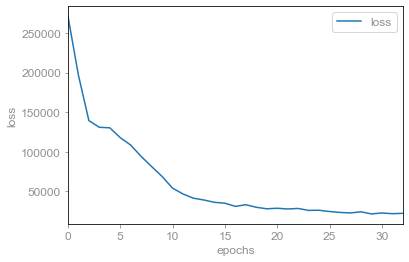

In [43]:
# Plot History
pd.DataFrame(history_m1.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [44]:
test_predict = model_1.predict(x_test)

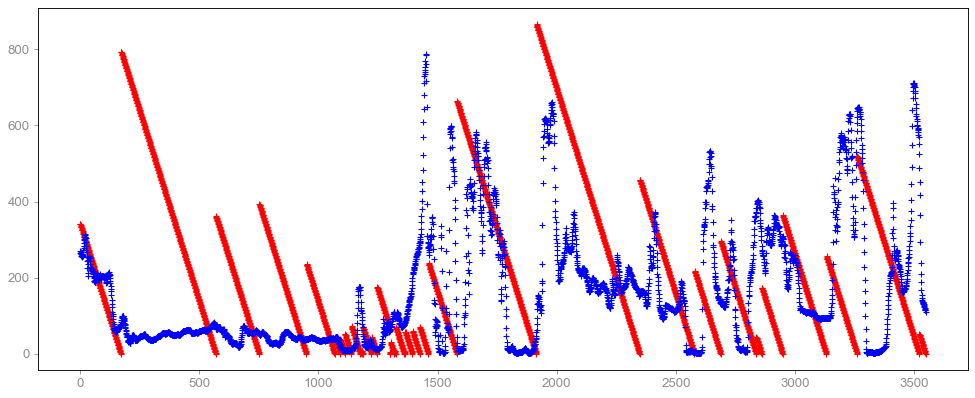

In [45]:
figure(figsize=(15, 6), dpi=80)
plt.plot(y_test,'r+')
plt.plot(test_predict,'b+')

In [46]:
import shap  # package used to calculate Shap values

# use Deep SHAP to explain test set predictions
#deep_explainer = shap.DeepExplainer(model_1.predict_proba, x_train)
#deep_shap_values = deep_explainer.shap_values(x_test)
#shap.force_plot(deep_explainer.expected_value[1], deep_shap_values[1], x_test)

## Truth

### Quantas quebras realmente ocorreram?

In [47]:
# Registro de quebras são aqueles onde RUL==0 (y_test==0)
np.unique(y_test==0,return_counts=True)

(array([False,  True]), array([3515,   34], dtype=int64))

### Quando ocorreram?

In [48]:
break_moments= np.where(y_test == 0)

In [49]:
list(break_moments)

[array([ 171,  569,  751,  949, 1068, 1091, 1111, 1138, 1175, 1181, 1186,
        1222, 1245, 1299, 1302, 1318, 1324, 1360, 1364, 1394, 1425, 1461,
        1581, 1914, 2348, 2578, 2688, 2837, 2860, 2948, 3131, 3260, 3521,
        3548], dtype=int64)]

## Previsões

### Quantas indicações abaixo de x minutos? 

In [50]:
np.unique(test_predict < 90 ,return_counts=True)

(array([False,  True]), array([1956, 1593], dtype=int64))

### Quando ocorreram?

In [51]:
np.where(test_predict < 90)[0]

array([ 139,  140,  141, ..., 3384, 3385, 3386], dtype=int64)

## Acertos
### Quantos e quando?

In [52]:
when_pred = np.where(test_predict < 90)[0].tolist()
when_true = np.where(y_test == 0)[0].tolist()

In [53]:
commonalities = set(when_pred) - (set(when_pred) - set(when_true))

In [54]:
len(commonalities)

18

In [55]:
commonalities

{171,
 569,
 751,
 949,
 1068,
 1091,
 1111,
 1138,
 1186,
 1222,
 1245,
 1299,
 1302,
 1360,
 1364,
 1581,
 1914,
 2578}

# Modeling 2: Binary Classification - Break in the next hour

## Dataset for model 2

In [56]:
pwbds_m2 = pwbds
yds_m2 = pwbds_m2.pop('NEXT_H')

In [57]:
num_steps = pwbds_m2.shape[1]
x_new, y_new = lstm_data_transform(pwbds_m2, yds_m2, num_steps=num_steps)
print ("The new shape of x is", x_new.shape)

The new shape of x is (17832, 62, 62)


In [58]:
train_ind = int(0.8 * pwbds.shape[0])
x_train = x_new[:train_ind]
y_train = y_new[:train_ind]
x_test = x_new[train_ind:]
y_test = y_new[train_ind:]

# Model 2

In [59]:
model_2 = keras.Sequential()
model_2.add(layers.LSTM(120, activation='tanh', input_shape=(num_steps, x_train.shape[2]), 
               return_sequences=False))
# Plus a 20% dropout rate
model_2.add(layers.Dropout(0.2))

# The second layer
#model_2.add(layers.LSTM(
#          units=60,
#          return_sequences=False))

# Plus a 20% dropout rate
#model_2.add(layers.Dropout(0.2))
#model_2.add(layers.Dense(units=60, activation='relu'))
#model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(units=30, activation='relu'))
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(units=1, activation='sigmoid'))
adam = keras.optimizers.Adam(lr=0.001)
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Verify the architecture 
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120)               87840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3630      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 91,501
Trainable params: 91,501
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
history_m2 = model_2.fit(
    x_train, 
    y_train, 
    epochs=40,
    callbacks=[callback]
#    batch_size=200, # 
#    validation_split=0.10 # Use 10% of data to evaluate the loss. (val_loss)
)

Epoch 1/40
14315/14315 [==============================] - 27s 2ms/sample - loss: 0.2146 - acc: 0.9032
Epoch 2/40
14315/14315 [==============================] - 25s 2ms/sample - loss: 0.0971 - acc: 0.9643
Epoch 3/40
14315/14315 [==============================] - 25s 2ms/sample - loss: 0.0822 - acc: 0.9702
Epoch 4/40
14315/14315 [==============================] - 27s 2ms/sample - loss: 0.0768 - acc: 0.9714
Epoch 5/40
14315/14315 [==============================] - 26s 2ms/sample - loss: 0.0718 - acc: 0.9737
Epoch 6/40
14315/14315 [==============================] - 26s 2ms/sample - loss: 0.0695 - acc: 0.9751
Epoch 7/40
14315/14315 [==============================] - 26s 2ms/sample - loss: 0.0663 - acc: 0.9775
Epoch 8/40
14315/14315 [==============================] - 26s 2ms/sample - loss: 0.0628 - acc: 0.9781
Epoch 9/40
14315/14315 [==============================] - 26s 2ms/sample - loss: 0.0663 - acc: 0.9767
Epoch 10/40
14315/14315 [==============================] - 26s 2ms/sample - loss: 

Text(0.5, 0, 'epochs')

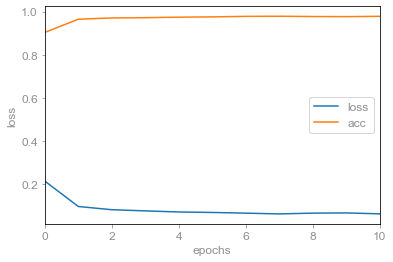

In [61]:
# Plot History
pd.DataFrame(history_m2.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [62]:
#scores_2 = model_2.evaluate(x_test, y_test, verbose=1, batch_size=200)
scores_2 = model_2.evaluate(x_test, y_test, verbose=1)
print('Training Accurracy: {}'.format(scores_2[1]))

3517/3517 [==============================] - 1s 389us/sample - loss: 1.2754 - acc: 0.5047
Training Accurracy: 0.504691481590271


In [63]:
# make predictions and compute confusion matrix
#y_pred = model_2.predict_classes(x_test,verbose=1, batch_size=200)
y_pred = model_2.predict_classes(x_test,verbose=1)
y_true = y_test
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

3517/3517 [==============================] - 1s 426us/sample
Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[ 941, 1742],
       [   0,  834]], dtype=int64)

In [64]:
# compute precision and recall
precision_test = precision_score(y_true, y_pred)
recall_test = recall_score(y_true, y_pred)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Precision:  0.32375776397515527 
 Test Recall:  1.0 
 Test F1 Score: 0.48914956011730204


In [65]:
cm = confusion_matrix(y_true, y_pred)

In [66]:
cmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred),
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)
print(cmtx)

        pred:0  pred:1
true:0     941    1742
true:1       0     834


In [67]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([2683,  834], dtype=int64))

# Random Forest

In [68]:
pwbds['NEXT_H'] = np.where(pwbds['RUL'] <= 60, 1, 0 )

In [69]:
pwbds.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,RUL,NEXT_H
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,518.0,0
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,516.0,0
2,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,514.0,0
3,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,512.0,0
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,510.0,0


In [70]:
pwbds.drop(['y','RUL'],axis=1,inplace=True)

In [71]:
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

# Get the number of rows in the data
nrows = pwbds.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(pwbds_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
pwbds_scaled = pd.DataFrame(
    np_data_scaled,
    columns=FEATURES
)

(17894, 50)


In [72]:
train_ind = int(0.8 * pwbds_scaled.shape[0])
x_train = pwbds_scaled[:train_ind]
y_train = pwbds.NEXT_H[:train_ind]
x_test = pwbds_scaled[train_ind:]
y_test = pwbds.NEXT_H[train_ind:]

In [73]:
from sklearn.ensemble import RandomForestClassifier as rfc
clf_rf = rfc(random_state=0).fit(x_train, y_train)

In [74]:
clf_rf.score(x_test, y_test)

0.6739312657166806

In [75]:
y_pred = clf_rf.predict(x_test)

In [76]:
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_test, y_pred)
cm

Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[2237,  508],
       [ 659,  175]], dtype=int64)